In [2]:
from plotting_functions import *

ModuleNotFoundError: No module named 'plotting_functions'

In [3]:
from matplotlib import pyplot as plt
from matplotlib import colors
from zipfile import ZipFile
import xarray as xr
import numpy as np
import glob
import time
from cartopy import crs as ccrs
from cartopy import feature
import sys
from matplotlib.font_manager import FontProperties

In [4]:
def gather_fire_seasons(seasonal_threshold, index, period = 'historical'):

    if period == 'historical':
        mode = 'h'
    if period == 'projected':
        mode = 's'

    t0 = time.time()

    mask = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                           'wildfires_theo_keeping/live/ensemble_data/'+
                           'mask_conus_2000_2009.nc').mask.to_numpy()

    paths = glob.glob('/rds/general/user/tk22/ephemeral/tmp/'+
                      f'p_????_{period}_annual_fires_705.nc')

    members = []
    for i, path in enumerate(paths):
        if i % 10 == 0:
            print(f'{i} of {len(paths)}\t({(time.time() - t0)/60:.2f} minutes)')
            sys.stdout.flush()
        ds = xr.open_dataset(path).load()
        members.append(ds.member.to_numpy()[0])
        temp = (ds.p > seasonal_threshold)
        temp = temp.resample(time = '1Y').sum() * mask

        if i == 0:
            lat = temp.latitude.to_numpy()
            lon = temp.longitude.to_numpy()
            yrs = np.arange(int(temp.time.dt.year[0]),int(temp.time.dt.year[-1])+1)
            fire_years = temp
        else:
            fire_years = np.concatenate((fire_years, temp), axis = 0)
        ds.close()
        temp.close()

    fire_years = xr.Dataset(data_vars = {'season_length': (
        ['member','time','latitude','longitude'], fire_years)},
                              coords = {'member': members,
                                        'time': yrs,
                                        'latitude': lat,
                                        'longitude': lon})
    return fire_years

In [5]:
index = 705
ds_re = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                        'wildfires_theo_keeping/live/ensemble_summaries/'+
                        f'p_class_B_19900101_20191231_obs_{index}.nc')
mask = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                       'wildfires_theo_keeping/live/ensemble_data/'+
                       'mask_conus_2000_2009.nc').mask.to_numpy()
# Threshold, half of the maximum fire week:
seasonal_threshold = (ds_re.p.rolling(time = 7).mean().max(dim = 'time')/2).to_numpy()
# Defining season length for reanalysis:
length_re = (ds_re.p > seasonal_threshold)
length_re = length_re.resample(time = '1Y').sum() * mask
length_re = length_re.to_dataset().rename({'p':'season_length'})
length_re.to_netcdf('/rds/general/user/tk22/ephemeral/ensemble_predictors/'+
                    'downscaled/season_length_reanalysis.nc')

----

In [6]:
index = 705


mask_h = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'mask_conus_2000_2009.nc').mask.to_numpy()

mask_s = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'mask_conus_2075_2084.nc').mask.to_numpy()

ds_re = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                        'wildfires_theo_keeping/live/ensemble_summaries/'+
                        f'p_class_B_19900101_20191231_obs_{index}.nc')

ds_hist = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                          'wildfires_theo_keeping/live/ensemble_summaries/'+
                          'season_length_historical.nc').season_length * mask_h
nan_mask = np.array(ds_hist.max(dim = ['member', 'time']) == 0, dtype = float)
nan_mask[nan_mask == 1] = np.nan
ds_hist = ds_hist * (nan_mask*0 + 1)

ds_proj = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                          'wildfires_theo_keeping/live/ensemble_summaries/'+
                          'season_length_projected.nc').season_length * mask_s

### Main Summary:

In [7]:
clist = ['#FAFA96', '#50B450', '#530000']
#clist = ['#C7D69E', '#88BB50', '#569D00', '#7A7A00', '#58490B']
#bounds = list(np.arange(0,365,30))
bounds = [0,10,30,60,120,180,240,300,360]

/var/tmp/pbs.126725.pbs/ipykernel_2224633/396609821.py:15: RuntimeWarning: Mean of empty slice
  length_obs_mean = np.nanmean(length_obs.to_numpy().astype(float), axis = 0)
/rds/general/user/tk22/home/miniconda3/envs/firepy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


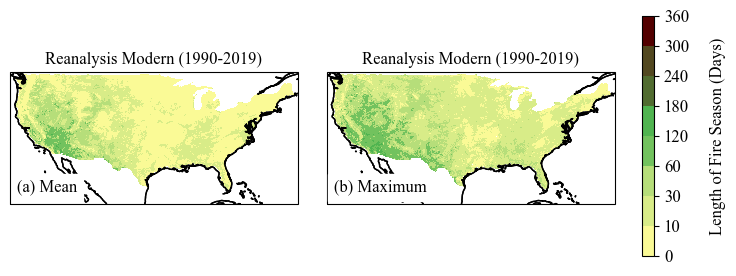

In [8]:
tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf',
                     size = 12)

ds_re = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                        'wildfires_theo_keeping/live/ensemble_summaries/'+
                        'season_length_reanalysis.nc')

#ds_re = ds_re.rolling(time = 30).mean() * mask_h
#ds_re = ds_re.p.coarsen(latitude  = 5, longitude = 5, boundary  = "trim").mean()

#seasonal_threshold = (ds_re.resample(time = '1Y').max().mean(dim = 'time')/2).to_numpy()
#length_obs = (ds_re > seasonal_threshold)
length_obs = ds_re.season_length

length_obs_mean = np.nanmean(length_obs.to_numpy().astype(float), axis = 0)
length_obs_mean[length_obs_mean == 0] = np.nan

length_obs_max = np.nanquantile(length_obs.to_numpy().astype(float), 0.9, axis = 0)
length_obs_max[length_obs_max == 0] = np.nan

fig, axs = plt.subplots(1, 2, figsize = (7.8,4),
                        subplot_kw={'projection': ccrs.PlateCarree()})

axs[0].set_global()
axs[0].coastlines()
axs[0].set_xlim(-125.5, -66.5)
axs[0].set_ylim(22.5, 49.5)
#bounds = list(np.arange(0,365,30))
num_c = len(bounds)+2
cmap = colors.LinearSegmentedColormap.from_list('cmap', clist, N = num_c)
norm = colors.BoundaryNorm(bounds, cmap.N, extend = 'neither')
im1 = axs[0].pcolormesh(
    length_obs.longitude, length_obs.latitude, length_obs_mean,
    norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
axs[0].coastlines()
axs[0].text(-124, 25, f'(a) Mean', color = 'k', font = tnr, 
              bbox = dict(facecolor = 'white', edgecolor = 'white'))
axs[0].set_title('Reanalysis Modern (1990-2019)', font = tnr)

axs[1].set_global()
axs[1].coastlines()
axs[1].set_xlim(-125.5, -66.5)
axs[1].set_ylim(22.5, 49.5)
#bounds = list(np.arange(0,365,30))
num_c = len(bounds)+2
cmap = colors.LinearSegmentedColormap.from_list('cmap', clist, N = num_c)
norm = colors.BoundaryNorm(bounds, cmap.N, extend = 'neither')
im1 = axs[1].pcolormesh(
    length_obs.longitude, length_obs.latitude, length_obs_max,
    norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
axs[1].coastlines()
axs[1].text(-124, 25, f'(b) Maximum', color = 'k', font = tnr, 
              bbox = dict(facecolor = 'white', edgecolor = 'white'))
axs[1].set_title('Reanalysis Modern (1990-2019)', font = tnr)

plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
fig.subplots_adjust(right = 0.9)

cbar_ax1 = fig.add_axes([0.935, 0.2, 0.016, 0.6])
cbar1 = fig.colorbar(im1, cax = cbar_ax1, extend = 'neither')

cbar1.set_label(f'Length of Fire Season (Days)',
                font = tnr, labelpad = 15)
cbar1.ax.set_yticks(bounds)
cbar1.ax.set_yticklabels(['0','10','30','60','120','180','240','300','360'],font = tnr)

plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
             f'final_figures/figures/supplementary_figure_4.jpg'), 
            bbox_inches = 'tight', facecolor = 'white', dpi = 300)
plt.show()

/rds/general/user/tk22/home/miniconda3/envs/firepy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/rds/general/user/tk22/home/miniconda3/envs/firepy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


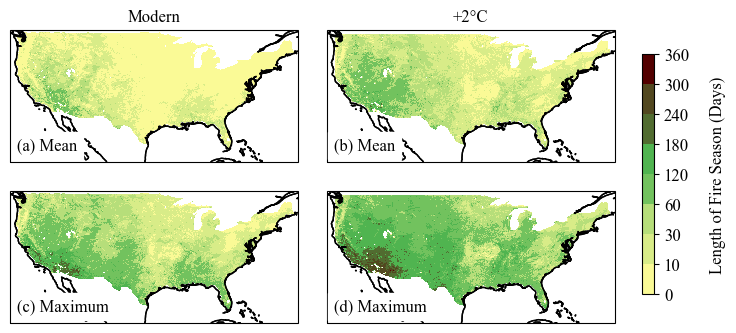

In [20]:
tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf',
                     size = 12)

fig, axs = plt.subplots(2, 2, figsize = (7.8,4),
                        subplot_kw={'projection': ccrs.PlateCarree()})

axs[0,0].set_global()
axs[0,0].coastlines()
axs[0,0].set_xlim(-125.5, -66.5)
axs[0,0].set_ylim(22.5, 49.5)
#bounds = list(np.arange(0,365,30))
num_c = len(bounds)+2
cmap = colors.LinearSegmentedColormap.from_list('cmap', clist, N = num_c)
norm = colors.BoundaryNorm(bounds, cmap.N, extend = 'neither')
im1 = axs[0,0].pcolormesh(
    ds_hist.longitude, ds_hist.latitude, ds_hist.mean(dim = ['member','time']),
    norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
axs[0,0].coastlines()
axs[0,0].text(-124, 25, f'(a) Mean', color = 'k', font = tnr, 
              bbox = dict(facecolor = 'white', edgecolor = 'white'))
axs[0,0].set_title('Modern', font = tnr)

axs[0,1].set_global()
axs[0,1].coastlines()
axs[0,1].set_xlim(-125.5, -66.5)
axs[0,1].set_ylim(22.5, 49.5)
#bounds = list(np.arange(0,365,30))
num_c = len(bounds)+2
cmap = colors.LinearSegmentedColormap.from_list('cmap', clist, N = num_c)
norm = colors.BoundaryNorm(bounds, cmap.N, extend = 'neither')
im1 = axs[0,1].pcolormesh(
    ds_proj.longitude, ds_proj.latitude, ds_proj.mean(dim = ['member','time']),
    norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
axs[0,1].coastlines()
axs[0,1].text(-124, 25, f'(b) Mean', color = 'k', font = tnr, 
              bbox = dict(facecolor = 'white', edgecolor = 'white'))
axs[0,1].set_title('+2°C', font = tnr)

axs[1,0].set_global()
axs[1,0].coastlines()
axs[1,0].set_xlim(-125.5, -66.5)
axs[1,0].set_ylim(22.5, 49.5)
#bounds = list(np.arange(0,365,30))
num_c = len(bounds)+2
cmap = colors.LinearSegmentedColormap.from_list('cmap', clist, N = num_c)
norm = colors.BoundaryNorm(bounds, cmap.N, extend = 'neither')
im1 = axs[1,0].pcolormesh(
    ds_hist.longitude, ds_hist.latitude, ds_hist.quantile(0.99,dim = ['member','time']),
    norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
axs[1,0].coastlines()
axs[1,0].text(-124, 25, f'(c) Maximum', color = 'k', font = tnr, 
              bbox = dict(facecolor = 'white', edgecolor = 'white'))


axs[1,1].set_global()
axs[1,1].coastlines()
axs[1,1].set_xlim(-125.5, -66.5)
axs[1,1].set_ylim(22.5, 49.5)
#bounds = list(np.arange(0,365,30))
num_c = len(bounds)+2
cmap = colors.LinearSegmentedColormap.from_list('cmap', clist, N = num_c)
norm = colors.BoundaryNorm(bounds, cmap.N, extend = 'neither')
im1 = axs[1,1].pcolormesh(
    ds_proj.longitude, ds_proj.latitude, ds_proj.quantile(0.99,dim = ['member','time']),
    norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
axs[1,1].coastlines()
axs[1,1].text(-124, 25, f'(d) Maximum', color = 'k', font = tnr, 
              bbox = dict(facecolor = 'white', edgecolor = 'white'))

plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
fig.subplots_adjust(right = 0.9)

cbar_ax1 = fig.add_axes([0.935, 0.2, 0.016, 0.6])
cbar1 = fig.colorbar(im1, cax = cbar_ax1, extend = 'neither')

cbar1.set_label(f'Length of Fire Season (Days)',
                font = tnr, labelpad = 15)
#fontsetter = [t.set_fontsize(12) for t in cbar_ax1.get_yticklabels()]
cbar1.ax.set_yticklabels(['0','10','30','60','120','180','240','300','360'],font = tnr)

plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
             f'final_figures/figures/figure_4.jpg'), 
            bbox_inches = 'tight', facecolor = 'white', dpi = 300)
plt.show()